<a href="https://colab.research.google.com/github/JiayiShou/MiCA/blob/main/ThreeAutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from PIL import Image

import numpy as np
from google.colab import files

In [ ]:
epochs = 50
lr_rate = 1e-3
batch_size = 128

### Stacked Autoencoder with FashionMNIST
This part of the code is altered from: 
https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/


In [ ]:
#utility 
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

In [ ]:
!mkdir FashionMNIST_Images
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
#trainloader has 60000/128 number of batches, testloade has 10000/128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [ ]:
print(trainset)

In [ ]:
class StackedAutoencoder(nn.Module):
  
  def __init__(self):
        super(StackedAutoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)

  def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(automodel_stacked.parameters(), lr=lr_rate)

In [ ]:
def train(model, trainloader, epochs):
    train_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.cuda()
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, epochs, loss))
        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch)
    return train_loss

def test_image_reconstruction(model, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.cuda()
        img = img.view(img.size(0), -1)
        outputs = model(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        #plt.imshow(img)
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

In [ ]:
automodel_stacked = StackedAutoencoder().cuda()
train_loss = train(automodel_stacked, trainloader, epochs)

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.title('Stacked Autoencoder Train Loss Epochs 50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print(train_loss[-1])
#plt.savefig('deep_ae_fashionmnist_loss.png')

In [ ]:
test_image_reconstruction(automodel_stacked, testloader)

In [ ]:
files.download('fashionmnist_reconstruction.png') 

###Denoised Autoencoder
Add Gaussian noise to the FasionMNIST data and then use the same structure of the stacked autoencoder

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        chance = (torch.rand(tensor.size())<0.25).int()
        return tensor + chance * torch.rand(tensor.size()) + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
!mkdir FashionMNIST_Images

transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 1.)
])

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


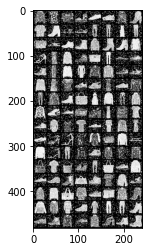

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=True)


In [ ]:
automodel_denoised = StackedAutoencoder().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(automodel_denoised.parameters(), lr=lr_rate)
train_loss = train(automodel_denoised, trainloader, epochs)

Epoch 1 of 50, Train Loss: 0.172
Epoch 2 of 50, Train Loss: 0.131
Epoch 3 of 50, Train Loss: 0.113
Epoch 4 of 50, Train Loss: 0.104
Epoch 5 of 50, Train Loss: 0.102
Epoch 6 of 50, Train Loss: 0.099
Epoch 7 of 50, Train Loss: 0.097
Epoch 8 of 50, Train Loss: 0.095
Epoch 9 of 50, Train Loss: 0.094
Epoch 10 of 50, Train Loss: 0.092
Epoch 11 of 50, Train Loss: 0.092
Epoch 12 of 50, Train Loss: 0.091
Epoch 13 of 50, Train Loss: 0.090
Epoch 14 of 50, Train Loss: 0.089
Epoch 15 of 50, Train Loss: 0.089
Epoch 16 of 50, Train Loss: 0.089
Epoch 17 of 50, Train Loss: 0.088
Epoch 18 of 50, Train Loss: 0.088
Epoch 19 of 50, Train Loss: 0.088
Epoch 20 of 50, Train Loss: 0.088
Epoch 21 of 50, Train Loss: 0.088
Epoch 22 of 50, Train Loss: 0.087
Epoch 23 of 50, Train Loss: 0.087
Epoch 24 of 50, Train Loss: 0.087
Epoch 25 of 50, Train Loss: 0.087
Epoch 26 of 50, Train Loss: 0.087
Epoch 27 of 50, Train Loss: 0.087
Epoch 28 of 50, Train Loss: 0.086
Epoch 29 of 50, Train Loss: 0.086
Epoch 30 of 50, Train L

0.0848919523359616


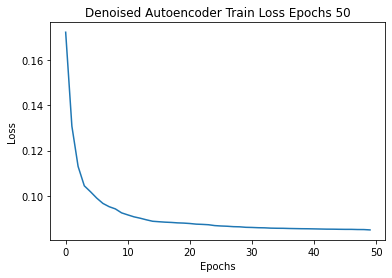

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.title('Denoised Autoencoder Train Loss Epochs 50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print(train_loss[-1])

In [ ]:
test_image_reconstruction(automodel_denoised, testloader)

In [ ]:
files.download('fashionmnist_reconstruction.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('linear_ae_image0.png')
files.download('linear_ae_image5.png')
files.download('linear_ae_image10.png')
files.download('linear_ae_image15.png')
files.download('linear_ae_image20.png')
files.download('linear_ae_image25.png')
files.download('linear_ae_image30.png')
files.download('linear_ae_image35.png')
files.download('linear_ae_image40.png')
files.download('linear_ae_image45.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Vatiational Autoencoder with FashionMNIST
Altered from here: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/


In [ ]:
features = 16
# Simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()

        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)

        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) 
        eps = torch.randn_like(std) 
        sample = mu + (eps * std) 
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] 
        log_var = x[:, 1, :]
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var

In [ ]:
VAE = LinearVAE().cuda()
optimizer = optim.Adam(VAE.parameters(), lr=lr_rate)
#criterion = nn.BCELoss(reduction='sum')
criterion = nn.MSELoss()

In [ ]:
def final_loss(mse_loss, mu, logvar):
    MSE = mse_loss 
    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE# + KLD
    

In [ ]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(trainset)/dataloader.batch_size)):
        data, _ = data
        data = data.cuda()
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        mse_loss = criterion(reconstruction, data)
        loss = final_loss(mse_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [ ]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(testset)/dataloader.batch_size)):
            data, _ = data
            data = data.cuda()
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            mse_loss = criterion(reconstruction, data)
            loss = final_loss(mse_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(testset)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                #save_image(both.cpu(), 'output{epoch}.png')
                save_image(both.cpu(), f"./outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [ ]:
!mkdir outputs

mkdir: cannot create directory ‘outputs’: File exists


In [ ]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(VAE, trainloader)
    val_epoch_loss = validate(VAE, testloader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")




  2%|▏         | 10/468 [00:00<00:04, 94.89it/s]

Epoch 1 of 50



 98%|█████████▊| 458/468 [00:05<00:00, 85.84it/s]
469it [00:05, 86.38it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 99.98it/s] 
79it [00:00, 100.04it/s]                       

  2%|▏         | 9/468 [00:00<00:05, 88.48it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 2 of 50



 97%|█████████▋| 453/468 [00:05<00:00, 85.99it/s]
469it [00:05, 85.35it/s]                         

 83%|████████▎ | 65/78 [00:00<00:00, 104.26it/s]
79it [00:00, 103.47it/s]                        

  2%|▏         | 10/468 [00:00<00:04, 94.31it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 3 of 50



 97%|█████████▋| 456/468 [00:05<00:00, 84.31it/s]
469it [00:05, 85.55it/s]                         

 83%|████████▎ | 65/78 [00:00<00:00, 106.13it/s]
79it [00:00, 102.36it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 86.07it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 4 of 50



 98%|█████████▊| 458/468 [00:05<00:00, 85.75it/s]
469it [00:05, 86.24it/s]                         

 82%|████████▏ | 64/78 [00:00<00:00, 100.58it/s]
79it [00:00, 100.99it/s]                       

  2%|▏         | 9/468 [00:00<00:05, 88.16it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 5 of 50



 97%|█████████▋| 455/468 [00:05<00:00, 87.27it/s]
469it [00:05, 85.81it/s]                         

 81%|████████  | 63/78 [00:00<00:00, 101.92it/s]
79it [00:00, 100.96it/s]                        

  2%|▏         | 10/468 [00:00<00:05, 90.68it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 6 of 50



 98%|█████████▊| 459/468 [00:05<00:00, 85.52it/s]
469it [00:05, 85.34it/s]                         

 81%|████████  | 63/78 [00:00<00:00, 100.24it/s]
79it [00:00, 101.51it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 86.28it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 7 of 50



 97%|█████████▋| 453/468 [00:05<00:00, 85.94it/s]
469it [00:05, 85.62it/s]                         

 85%|████████▍ | 66/78 [00:00<00:00, 104.23it/s]
79it [00:00, 103.18it/s]                        

  2%|▏         | 8/468 [00:00<00:05, 77.53it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 8 of 50



 97%|█████████▋| 455/468 [00:05<00:00, 83.67it/s]
469it [00:05, 82.85it/s]                         

 82%|████████▏ | 64/78 [00:00<00:00, 101.40it/s]
79it [00:00, 99.31it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 86.68it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 9 of 50



 98%|█████████▊| 459/468 [00:05<00:00, 84.01it/s]
469it [00:05, 84.43it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 98.14it/s]
79it [00:00, 97.24it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 88.31it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 10 of 50



 98%|█████████▊| 458/468 [00:05<00:00, 84.52it/s]
469it [00:05, 84.56it/s]                         

 81%|████████  | 63/78 [00:00<00:00, 98.98it/s] 
79it [00:00, 98.71it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 89.00it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 11 of 50



 97%|█████████▋| 452/468 [00:05<00:00, 83.08it/s]
469it [00:05, 84.94it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 99.40it/s]
79it [00:00, 101.42it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 88.96it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 12 of 50



 98%|█████████▊| 459/468 [00:05<00:00, 85.25it/s]
469it [00:05, 84.49it/s]                         

 82%|████████▏ | 64/78 [00:00<00:00, 101.11it/s]
79it [00:00, 101.40it/s]                        

  2%|▏         | 8/468 [00:00<00:05, 78.45it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 13 of 50



 98%|█████████▊| 457/468 [00:05<00:00, 82.27it/s]
469it [00:05, 84.09it/s]                         

 81%|████████  | 63/78 [00:00<00:00, 98.12it/s] 
79it [00:00, 100.77it/s]                       

  2%|▏         | 10/468 [00:00<00:05, 91.52it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 14 of 50



 96%|█████████▋| 451/468 [00:05<00:00, 82.18it/s]
469it [00:05, 84.78it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 96.96it/s]
79it [00:00, 98.95it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 83.57it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 15 of 50



 98%|█████████▊| 460/468 [00:05<00:00, 84.47it/s]
469it [00:05, 84.38it/s]

 82%|████████▏ | 64/78 [00:00<00:00, 101.55it/s]
79it [00:00, 99.65it/s]                        

  2%|▏         | 8/468 [00:00<00:06, 76.52it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 16 of 50



 98%|█████████▊| 459/468 [00:05<00:00, 85.14it/s]
469it [00:05, 84.23it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 93.23it/s]
79it [00:00, 97.61it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 88.39it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 17 of 50



 98%|█████████▊| 459/468 [00:05<00:00, 85.60it/s]
469it [00:05, 84.26it/s]                         

 81%|████████  | 63/78 [00:00<00:00, 98.58it/s]
79it [00:00, 97.99it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 89.20it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 18 of 50



 97%|█████████▋| 452/468 [00:05<00:00, 82.31it/s]
469it [00:05, 82.53it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 94.67it/s]
79it [00:00, 96.76it/s]                        

  2%|▏         | 8/468 [00:00<00:05, 79.62it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 19 of 50



 97%|█████████▋| 452/468 [00:05<00:00, 85.25it/s]
469it [00:05, 81.95it/s]                         

 77%|███████▋  | 60/78 [00:00<00:00, 97.44it/s]
79it [00:00, 99.78it/s]                         

  1%|▏         | 7/468 [00:00<00:06, 68.90it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 20 of 50



 97%|█████████▋| 455/468 [00:05<00:00, 83.02it/s]
469it [00:05, 82.81it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 97.04it/s] 
79it [00:00, 98.13it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 87.28it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 21 of 50



 97%|█████████▋| 455/468 [00:05<00:00, 83.35it/s]
469it [00:05, 83.03it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 96.88it/s]
79it [00:00, 97.64it/s]                        

  2%|▏         | 8/468 [00:00<00:05, 78.34it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 22 of 50



 97%|█████████▋| 456/468 [00:05<00:00, 82.24it/s]
469it [00:05, 82.33it/s]                         

 77%|███████▋  | 60/78 [00:00<00:00, 95.02it/s]
79it [00:00, 96.56it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 87.70it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 23 of 50



 97%|█████████▋| 455/468 [00:05<00:00, 82.64it/s]
469it [00:05, 82.61it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 94.29it/s]
79it [00:00, 95.90it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 87.44it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 24 of 50



 98%|█████████▊| 458/468 [00:05<00:00, 82.87it/s]
469it [00:05, 81.83it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 96.65it/s]
79it [00:00, 98.36it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 85.20it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 25 of 50



 98%|█████████▊| 457/468 [00:05<00:00, 82.64it/s]
469it [00:05, 82.39it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 97.39it/s]
79it [00:00, 97.49it/s]                        

  2%|▏         | 8/468 [00:00<00:06, 75.88it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 26 of 50



 97%|█████████▋| 455/468 [00:05<00:00, 83.11it/s]
469it [00:05, 82.22it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 98.52it/s]
79it [00:00, 96.95it/s]                        

  2%|▏         | 8/468 [00:00<00:05, 79.50it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 27 of 50



 97%|█████████▋| 455/468 [00:05<00:00, 81.29it/s]
469it [00:05, 81.78it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 97.67it/s]
79it [00:00, 96.72it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 87.02it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 28 of 50



 97%|█████████▋| 453/468 [00:05<00:00, 80.68it/s]
469it [00:05, 81.95it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 94.77it/s]
79it [00:00, 96.84it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 85.71it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 29 of 50



 97%|█████████▋| 455/468 [00:05<00:00, 80.30it/s]
469it [00:05, 80.43it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 96.71it/s] 
79it [00:00, 97.47it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 87.38it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 30 of 50



 98%|█████████▊| 459/468 [00:05<00:00, 82.32it/s]
469it [00:05, 80.97it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 98.45it/s]
79it [00:00, 97.29it/s]                        

  2%|▏         | 8/468 [00:00<00:05, 78.51it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 31 of 50



 99%|█████████▊| 461/468 [00:05<00:00, 78.33it/s]
469it [00:05, 79.56it/s]

 76%|███████▌  | 59/78 [00:00<00:00, 95.89it/s]
79it [00:00, 97.25it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 82.18it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 32 of 50



 97%|█████████▋| 456/468 [00:05<00:00, 84.09it/s]
469it [00:05, 81.74it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 97.93it/s]
79it [00:00, 97.80it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 84.72it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 33 of 50



 97%|█████████▋| 452/468 [00:05<00:00, 81.17it/s]
469it [00:05, 81.36it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 96.53it/s]
79it [00:00, 97.85it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 88.77it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 34 of 50



 97%|█████████▋| 454/468 [00:05<00:00, 79.41it/s]
469it [00:05, 79.65it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 94.82it/s]
79it [00:00, 95.53it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 85.54it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 35 of 50



 97%|█████████▋| 454/468 [00:05<00:00, 80.44it/s]
469it [00:05, 79.54it/s]                         

 85%|████████▍ | 66/78 [00:00<00:00, 89.44it/s]
79it [00:00, 91.64it/s]                        

  2%|▏         | 10/468 [00:00<00:05, 90.65it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 36 of 50



 97%|█████████▋| 452/468 [00:05<00:00, 81.11it/s]
469it [00:05, 80.79it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 98.23it/s]
79it [00:00, 95.89it/s]                        

  2%|▏         | 10/468 [00:00<00:05, 89.52it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 37 of 50



 98%|█████████▊| 458/468 [00:05<00:00, 80.22it/s]
469it [00:05, 80.44it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 97.10it/s]
79it [00:00, 96.99it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 82.75it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 38 of 50



 98%|█████████▊| 457/468 [00:05<00:00, 79.14it/s]
469it [00:05, 80.39it/s]                         

 88%|████████▊ | 69/78 [00:00<00:00, 88.29it/s]
79it [00:00, 90.47it/s]                        

  2%|▏         | 8/468 [00:00<00:06, 74.10it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 39 of 50



 97%|█████████▋| 455/468 [00:05<00:00, 84.16it/s]
469it [00:05, 81.65it/s]                         

 82%|████████▏ | 64/78 [00:00<00:00, 102.41it/s]
79it [00:00, 99.76it/s]                         

  2%|▏         | 9/468 [00:00<00:05, 82.42it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 40 of 50



 98%|█████████▊| 457/468 [00:05<00:00, 83.73it/s]
469it [00:05, 83.64it/s]                         

 81%|████████  | 63/78 [00:00<00:00, 100.57it/s]
79it [00:00, 98.94it/s]                        

  2%|▏         | 8/468 [00:00<00:05, 78.89it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 41 of 50



 98%|█████████▊| 457/468 [00:05<00:00, 83.97it/s]
469it [00:05, 83.48it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 98.50it/s]
79it [00:00, 99.04it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 82.50it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 42 of 50



 97%|█████████▋| 455/468 [00:05<00:00, 82.28it/s]
469it [00:05, 82.94it/s]                         

 82%|████████▏ | 64/78 [00:00<00:00, 99.98it/s] 
79it [00:00, 98.63it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 82.17it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 43 of 50



 98%|█████████▊| 457/468 [00:05<00:00, 83.64it/s]
469it [00:05, 83.28it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 100.76it/s]
79it [00:00, 100.13it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 87.68it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 44 of 50



 98%|█████████▊| 458/468 [00:05<00:00, 83.13it/s]
469it [00:05, 81.32it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 99.53it/s] 
79it [00:00, 99.31it/s]                        

  2%|▏         | 10/468 [00:00<00:05, 91.51it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 45 of 50



 97%|█████████▋| 456/468 [00:05<00:00, 84.11it/s]
469it [00:05, 83.20it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 99.56it/s]
79it [00:00, 98.22it/s]                        

  2%|▏         | 8/468 [00:00<00:05, 78.24it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 46 of 50



 98%|█████████▊| 458/468 [00:05<00:00, 82.34it/s]
469it [00:05, 82.90it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 95.46it/s]
79it [00:00, 97.01it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 84.90it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 47 of 50



 97%|█████████▋| 454/468 [00:05<00:00, 81.28it/s]
469it [00:05, 81.73it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 95.61it/s]
79it [00:00, 97.20it/s]                        

  2%|▏         | 8/468 [00:00<00:06, 75.64it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 48 of 50



 98%|█████████▊| 458/468 [00:05<00:00, 85.38it/s]
469it [00:05, 81.81it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 97.05it/s]
79it [00:00, 97.94it/s]                        

  2%|▏         | 8/468 [00:00<00:06, 69.78it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 49 of 50



 98%|█████████▊| 459/468 [00:05<00:00, 84.77it/s]
469it [00:05, 82.07it/s]                         

 78%|███████▊  | 61/78 [00:00<00:00, 97.41it/s]
79it [00:00, 98.17it/s]                        

  2%|▏         | 9/468 [00:00<00:05, 89.62it/s]

Train Loss: 0.0001
Val Loss: 0.0001
Epoch 50 of 50



 98%|█████████▊| 457/468 [00:05<00:00, 83.69it/s]
469it [00:05, 83.59it/s]                         

 79%|███████▉  | 62/78 [00:00<00:00, 96.62it/s] 
79it [00:00, 98.67it/s]                        

Train Loss: 0.0001
Val Loss: 0.0001


0.000685760660469532


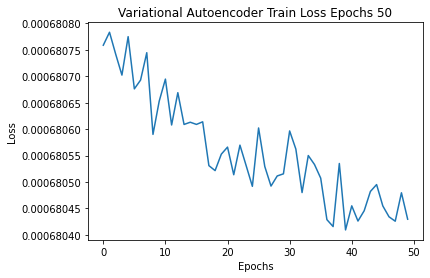

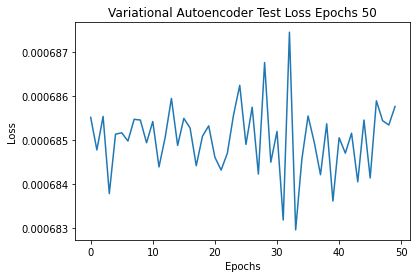

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.title('Variational Autoencoder Train Loss Epochs 50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.figure()
plt.plot(val_loss)
plt.title('Variational Autoencoder Test Loss Epochs 50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print(val_loss[-1])

In [ ]:
%ls
#files.download ('output\{epoch\}.png')


data/  FashionMNIST_Images/  output{epoch}.png  outputs/  sample_data/


In [ ]:
files.download('output{epoch}.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cd outputs/


/content/outputs


In [ ]:
ls

data/  FashionMNIST_Images/  output{epoch}.png  outputs/  sample_data/
